### 1. 모듈 임포트

In [1]:
import numpy as np  # 수치 계산을 위한 라이브러리
import matplotlib.pyplot as plt # 데이터 시각화를 위한 라이브러리

import torch # PyTorch 라이브러리
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 함수
from torchvision import transforms, datasets # 이미지 변환 및 데이터셋

### 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print('파이토치 버전 :', torch.__version__, '사용 디바이스 :', device)

BATCH_SIZE = 32 # 배치 크기
EPOCHS = 10 # 학습 반복 횟수

파이토치 버전 : 2.6.0+cu124 사용 디바이스 : cuda


### 3. MNIST 데이터 다운로드 (Train set, Test set 분리하기)

In [3]:
train_dataset = datasets.FashionMNIST(
    root='../data/FashionMNIST', # 데이터셋 저장 경로
    train=True, # 학습용 데이터셋 여부
    download = True, # 데이터셋 다운로드 여부
    transform=transforms.ToTensor() # 이미지 데이터를 텐서로 변환
)

test_dataset = datasets.FashionMNIST(
    root='../data/FashionMNIST', # 데이터셋 저장 경로
    train=False, # 테스트용 데이터셋 여부
    download = True, # 데이터셋 다운로드 여부
    transform=transforms.ToTensor() # 이미지 데이터를 텐서로 변환
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, # 학습용 데이터셋
    batch_size=BATCH_SIZE, # 배치 크기
    shuffle=True # 매 epoch마다 데이터 섞기
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, # 테스트용 데이터셋
    batch_size=BATCH_SIZE, # 배치 크기
    shuffle=False # 테스트 데이터는 섞지 않음
)

100.0%
100.0%
100.0%
100.0%


### 4. 데이터 확인하기

X_train 크기: torch.Size([32, 1, 28, 28]) X_train 타입: torch.FloatTensor
y_train 크기: torch.Size([32]) y_train 타입: torch.LongTensor


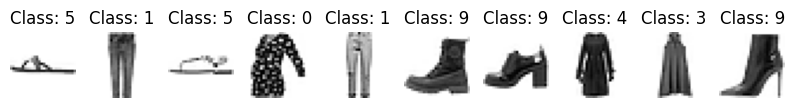

In [4]:
for (X_train, y_train) in train_loader:
    print('X_train 크기:', X_train.size(), 'X_train 타입:', X_train.type())
    print('y_train 크기:', y_train.size(), 'y_train 타입:', y_train.type())
    break   # 첫 번째 배치만 확인

pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize)) # 그래프 크기 설정

for i in range(10):
    plt.subplot(1, 10, i + 1) # 1행 10열의 서브플롯 생성
    plt.axis('off') # 축 숨기기
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r') # 이미지 출력
    plt.title('Class: ' + str(y_train[i].item())) # 클래스 레이블 출력

### 5. AutoEncoder(AE) 모델 설계하기

In [8]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),  # 입력층에서 은닉층으로
            nn.ReLU(),               # ReLU 활성화 함수
            nn.Linear(512, 256),     # 은닉층에서 잠재 공간으로
            nn.ReLU(),               # ReLU 활성화 함수
            nn.Linear(256, 32),      # 잠재 공간
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),      # 잠재 공간에서 은닉층으로
            nn.ReLU(),               # ReLU 활성화 함수
            nn.Linear(256, 512),     # 은닉층에서 출력층으로
            nn.ReLU(),               # ReLU 활성화 함수
            nn.Linear(512, 28 * 28), # 출력층
        )

    def forward(self, x):
        encoded = self.encoder(x) # 인코더 통과
        decoded = self.decoder(encoded) # 디코더 통과

        return encoded, decoded

### 6. Optimizer, Objective Function 설정하기

In [9]:
model = AE().to(device) # 모델을 디바이스로 이동

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam 옵티마이저
criterion = nn.MSELoss() # 평균 제곱 오차 손실 함수

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


### 7. AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의

In [10]:
def train(model, train_loader, optimizer, log_interval):
    model.train() # 모델을 학습 모드로 설정
    
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.view(-1, 28 * 28).to(device) # 이미지 데이터를 평탄화하고 디바이스로 이동
        target = image.view(-1, 28 * 28).to(device) # 타겟 데이터를 평탄화하고 디바이스로 이동
        
        optimizer.zero_grad() # 기울기 초기화

        encoded, decoded = model(image) # 모델에 입력 데이터 통과
       
        losss = criterion(decoded, target) # 손실 계산
        losss.backward() # 역전파로 기울기 계산
        optimizer.step() # 가중치 업데이트

        if batch_idx % log_interval == 0:   # 일정 간격마다 로그 출력
            print('학습 Epoch: {} [{}/{} ({:.0f}%)]\t학습 손실(Loss) : {:.6f}'.format(
                epoch, batch_idx * len(image), # 현재까지 학습한 데이터 수
                len(train_loader.dataset), # 전체 학습 데이터 수
                100. * batch_idx / len(train_loader), # 학습 진행률
                losss.item() # 현재 배치의 손실 값
            ))


### 8. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

In [11]:
def evaluate(model, test_loader):
    model.eval() # 모델을 평가 모드로 설정
    test_loss = 0   # 테스트 손실 초기화
    
    real_image = []  # 실제 이미지 저장 리스트
    gen_image = []   # 생성된 이미지 저장 리스트

    with torch.no_grad(): # 평가 시에는 기울기 계산하지 않음
        for image, _ in test_loader:
            image = image.view(-1, 28 * 28).to(device) # 이미지 데이터를 평탄화하고 디바이스로 이동
            target = image.view(-1, 28 * 28).to(device) # 타겟 데이터를 평탄화하고 디바이스로 이동
            encoded, decoded = model(image) # 모델에 이미지 입력하여 출력 계산

            test_loss += criterion(decoded, image).item() # 배치 손실 누적
            real_image.append(image.to("cpu"))  # 실제 이미지 저장
            gen_image.append(decoded.to("cpu")) # 생성된 이미지 저장

    test_loss /= len(test_loader.dataset) # 평균 손실 계산
    
    return test_loss, real_image, gen_image # 평가 손실과 실제 이미지, 생성된 이미지 반환

### 9. AutoEncoder 학습 실행하며 Test set의 Reconstruction Error 확인하기

학습 Epoch: 1 [0/60000 (0%)]	학습 손실(Loss) : 0.192521
학습 Epoch: 1 [6400/60000 (11%)]	학습 손실(Loss) : 0.026004
학습 Epoch: 1 [12800/60000 (21%)]	학습 손실(Loss) : 0.024399
학습 Epoch: 1 [19200/60000 (32%)]	학습 손실(Loss) : 0.022681
학습 Epoch: 1 [25600/60000 (43%)]	학습 손실(Loss) : 0.018925
학습 Epoch: 1 [32000/60000 (53%)]	학습 손실(Loss) : 0.016863
학습 Epoch: 1 [38400/60000 (64%)]	학습 손실(Loss) : 0.015826
학습 Epoch: 1 [44800/60000 (75%)]	학습 손실(Loss) : 0.019381
학습 Epoch: 1 [51200/60000 (85%)]	학습 손실(Loss) : 0.020974
학습 Epoch: 1 [57600/60000 (96%)]	학습 손실(Loss) : 0.016024

-------------------------------------------------------------------------------------
Epoch 1:      Test Loss: 0.0005
-------------------------------------------------------------------------------------



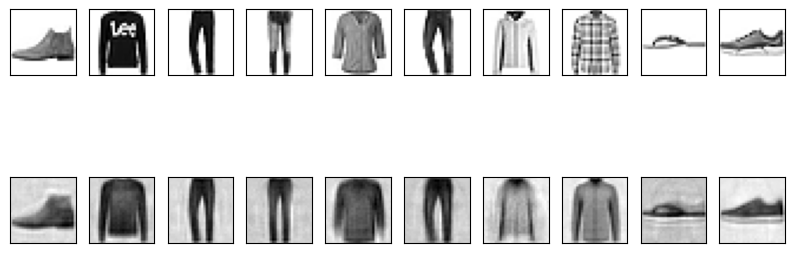

학습 Epoch: 2 [0/60000 (0%)]	학습 손실(Loss) : 0.018491
학습 Epoch: 2 [6400/60000 (11%)]	학습 손실(Loss) : 0.015051
학습 Epoch: 2 [12800/60000 (21%)]	학습 손실(Loss) : 0.017374
학습 Epoch: 2 [19200/60000 (32%)]	학습 손실(Loss) : 0.014298
학습 Epoch: 2 [25600/60000 (43%)]	학습 손실(Loss) : 0.012105
학습 Epoch: 2 [32000/60000 (53%)]	학습 손실(Loss) : 0.012345
학습 Epoch: 2 [38400/60000 (64%)]	학습 손실(Loss) : 0.012190
학습 Epoch: 2 [44800/60000 (75%)]	학습 손실(Loss) : 0.014411
학습 Epoch: 2 [51200/60000 (85%)]	학습 손실(Loss) : 0.013036
학습 Epoch: 2 [57600/60000 (96%)]	학습 손실(Loss) : 0.015243

-------------------------------------------------------------------------------------
Epoch 2:      Test Loss: 0.0004
-------------------------------------------------------------------------------------



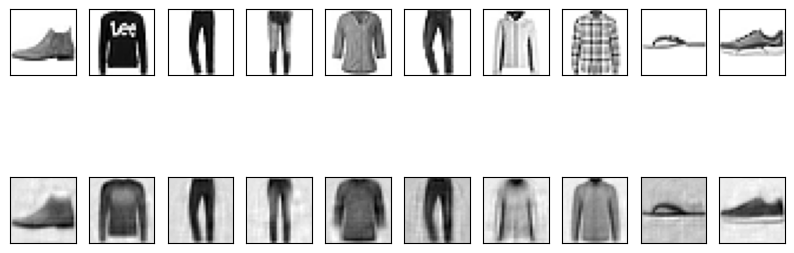

학습 Epoch: 3 [0/60000 (0%)]	학습 손실(Loss) : 0.011280
학습 Epoch: 3 [6400/60000 (11%)]	학습 손실(Loss) : 0.013913
학습 Epoch: 3 [12800/60000 (21%)]	학습 손실(Loss) : 0.011407
학습 Epoch: 3 [19200/60000 (32%)]	학습 손실(Loss) : 0.014335
학습 Epoch: 3 [25600/60000 (43%)]	학습 손실(Loss) : 0.012765
학습 Epoch: 3 [32000/60000 (53%)]	학습 손실(Loss) : 0.013147
학습 Epoch: 3 [38400/60000 (64%)]	학습 손실(Loss) : 0.012518
학습 Epoch: 3 [44800/60000 (75%)]	학습 손실(Loss) : 0.011419
학습 Epoch: 3 [51200/60000 (85%)]	학습 손실(Loss) : 0.009247
학습 Epoch: 3 [57600/60000 (96%)]	학습 손실(Loss) : 0.012003

-------------------------------------------------------------------------------------
Epoch 3:      Test Loss: 0.0004
-------------------------------------------------------------------------------------



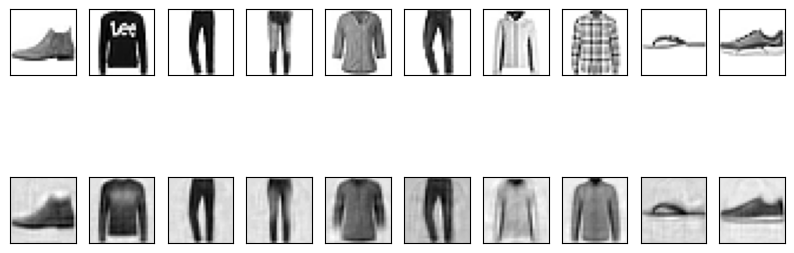

학습 Epoch: 4 [0/60000 (0%)]	학습 손실(Loss) : 0.008374
학습 Epoch: 4 [6400/60000 (11%)]	학습 손실(Loss) : 0.013731
학습 Epoch: 4 [12800/60000 (21%)]	학습 손실(Loss) : 0.012369
학습 Epoch: 4 [19200/60000 (32%)]	학습 손실(Loss) : 0.013076
학습 Epoch: 4 [25600/60000 (43%)]	학습 손실(Loss) : 0.013813
학습 Epoch: 4 [32000/60000 (53%)]	학습 손실(Loss) : 0.009285
학습 Epoch: 4 [38400/60000 (64%)]	학습 손실(Loss) : 0.012184
학습 Epoch: 4 [44800/60000 (75%)]	학습 손실(Loss) : 0.009809
학습 Epoch: 4 [51200/60000 (85%)]	학습 손실(Loss) : 0.012785
학습 Epoch: 4 [57600/60000 (96%)]	학습 손실(Loss) : 0.011084

-------------------------------------------------------------------------------------
Epoch 4:      Test Loss: 0.0004
-------------------------------------------------------------------------------------



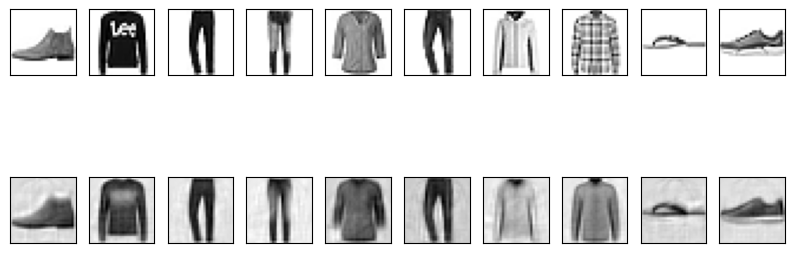

학습 Epoch: 5 [0/60000 (0%)]	학습 손실(Loss) : 0.010401
학습 Epoch: 5 [6400/60000 (11%)]	학습 손실(Loss) : 0.011179
학습 Epoch: 5 [12800/60000 (21%)]	학습 손실(Loss) : 0.012665
학습 Epoch: 5 [19200/60000 (32%)]	학습 손실(Loss) : 0.009752
학습 Epoch: 5 [25600/60000 (43%)]	학습 손실(Loss) : 0.009932
학습 Epoch: 5 [32000/60000 (53%)]	학습 손실(Loss) : 0.011735
학습 Epoch: 5 [38400/60000 (64%)]	학습 손실(Loss) : 0.010590
학습 Epoch: 5 [44800/60000 (75%)]	학습 손실(Loss) : 0.010773
학습 Epoch: 5 [51200/60000 (85%)]	학습 손실(Loss) : 0.010307
학습 Epoch: 5 [57600/60000 (96%)]	학습 손실(Loss) : 0.009194

-------------------------------------------------------------------------------------
Epoch 5:      Test Loss: 0.0003
-------------------------------------------------------------------------------------



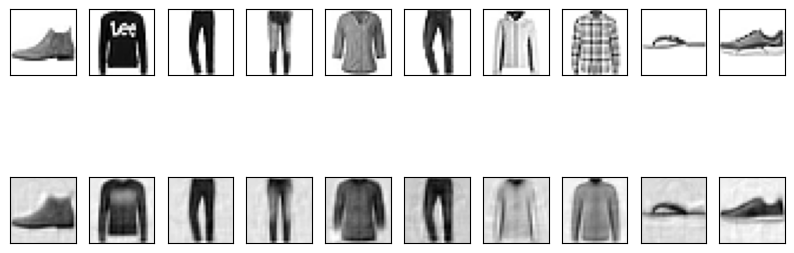

학습 Epoch: 6 [0/60000 (0%)]	학습 손실(Loss) : 0.010957
학습 Epoch: 6 [6400/60000 (11%)]	학습 손실(Loss) : 0.010113
학습 Epoch: 6 [12800/60000 (21%)]	학습 손실(Loss) : 0.012033
학습 Epoch: 6 [19200/60000 (32%)]	학습 손실(Loss) : 0.009915
학습 Epoch: 6 [25600/60000 (43%)]	학습 손실(Loss) : 0.011721
학습 Epoch: 6 [32000/60000 (53%)]	학습 손실(Loss) : 0.009670
학습 Epoch: 6 [38400/60000 (64%)]	학습 손실(Loss) : 0.008858
학습 Epoch: 6 [44800/60000 (75%)]	학습 손실(Loss) : 0.009139
학습 Epoch: 6 [51200/60000 (85%)]	학습 손실(Loss) : 0.010369
학습 Epoch: 6 [57600/60000 (96%)]	학습 손실(Loss) : 0.010784

-------------------------------------------------------------------------------------
Epoch 6:      Test Loss: 0.0003
-------------------------------------------------------------------------------------



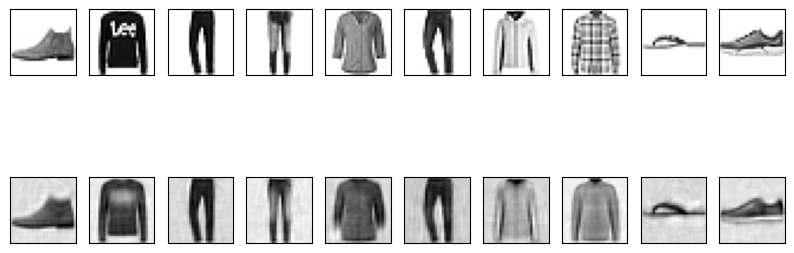

학습 Epoch: 7 [0/60000 (0%)]	학습 손실(Loss) : 0.009905
학습 Epoch: 7 [6400/60000 (11%)]	학습 손실(Loss) : 0.010234
학습 Epoch: 7 [12800/60000 (21%)]	학습 손실(Loss) : 0.010828
학습 Epoch: 7 [19200/60000 (32%)]	학습 손실(Loss) : 0.011157
학습 Epoch: 7 [25600/60000 (43%)]	학습 손실(Loss) : 0.012388
학습 Epoch: 7 [32000/60000 (53%)]	학습 손실(Loss) : 0.010139
학습 Epoch: 7 [38400/60000 (64%)]	학습 손실(Loss) : 0.008398
학습 Epoch: 7 [44800/60000 (75%)]	학습 손실(Loss) : 0.011053
학습 Epoch: 7 [51200/60000 (85%)]	학습 손실(Loss) : 0.007339
학습 Epoch: 7 [57600/60000 (96%)]	학습 손실(Loss) : 0.010303

-------------------------------------------------------------------------------------
Epoch 7:      Test Loss: 0.0003
-------------------------------------------------------------------------------------



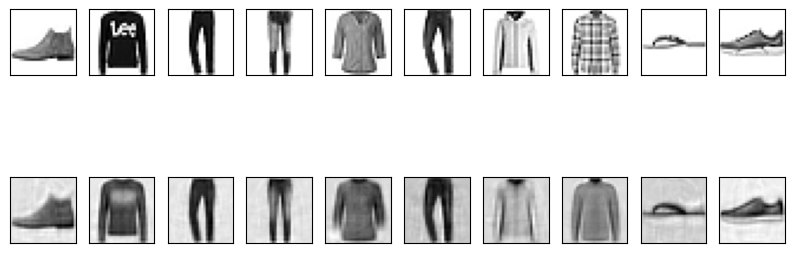

학습 Epoch: 8 [0/60000 (0%)]	학습 손실(Loss) : 0.012186
학습 Epoch: 8 [6400/60000 (11%)]	학습 손실(Loss) : 0.010456
학습 Epoch: 8 [12800/60000 (21%)]	학습 손실(Loss) : 0.007684
학습 Epoch: 8 [19200/60000 (32%)]	학습 손실(Loss) : 0.011903
학습 Epoch: 8 [25600/60000 (43%)]	학습 손실(Loss) : 0.012803
학습 Epoch: 8 [32000/60000 (53%)]	학습 손실(Loss) : 0.007913
학습 Epoch: 8 [38400/60000 (64%)]	학습 손실(Loss) : 0.011139
학습 Epoch: 8 [44800/60000 (75%)]	학습 손실(Loss) : 0.011129
학습 Epoch: 8 [51200/60000 (85%)]	학습 손실(Loss) : 0.010830
학습 Epoch: 8 [57600/60000 (96%)]	학습 손실(Loss) : 0.007377

-------------------------------------------------------------------------------------
Epoch 8:      Test Loss: 0.0003
-------------------------------------------------------------------------------------



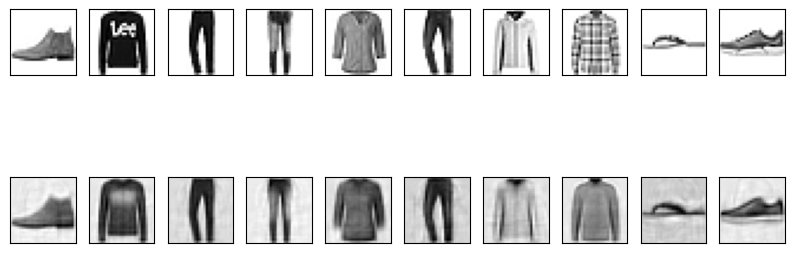

학습 Epoch: 9 [0/60000 (0%)]	학습 손실(Loss) : 0.009361
학습 Epoch: 9 [6400/60000 (11%)]	학습 손실(Loss) : 0.009924
학습 Epoch: 9 [12800/60000 (21%)]	학습 손실(Loss) : 0.010756
학습 Epoch: 9 [19200/60000 (32%)]	학습 손실(Loss) : 0.008778
학습 Epoch: 9 [25600/60000 (43%)]	학습 손실(Loss) : 0.009726
학습 Epoch: 9 [32000/60000 (53%)]	학습 손실(Loss) : 0.008418
학습 Epoch: 9 [38400/60000 (64%)]	학습 손실(Loss) : 0.009524
학습 Epoch: 9 [44800/60000 (75%)]	학습 손실(Loss) : 0.010169
학습 Epoch: 9 [51200/60000 (85%)]	학습 손실(Loss) : 0.010209
학습 Epoch: 9 [57600/60000 (96%)]	학습 손실(Loss) : 0.010734

-------------------------------------------------------------------------------------
Epoch 9:      Test Loss: 0.0003
-------------------------------------------------------------------------------------



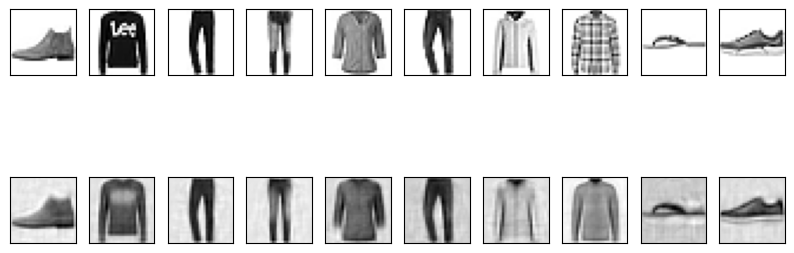

학습 Epoch: 10 [0/60000 (0%)]	학습 손실(Loss) : 0.008824
학습 Epoch: 10 [6400/60000 (11%)]	학습 손실(Loss) : 0.012893
학습 Epoch: 10 [12800/60000 (21%)]	학습 손실(Loss) : 0.008376
학습 Epoch: 10 [19200/60000 (32%)]	학습 손실(Loss) : 0.009730
학습 Epoch: 10 [25600/60000 (43%)]	학습 손실(Loss) : 0.008593
학습 Epoch: 10 [32000/60000 (53%)]	학습 손실(Loss) : 0.009049
학습 Epoch: 10 [38400/60000 (64%)]	학습 손실(Loss) : 0.009657
학습 Epoch: 10 [44800/60000 (75%)]	학습 손실(Loss) : 0.009607
학습 Epoch: 10 [51200/60000 (85%)]	학습 손실(Loss) : 0.009380
학습 Epoch: 10 [57600/60000 (96%)]	학습 손실(Loss) : 0.010519

-------------------------------------------------------------------------------------
Epoch 10:      Test Loss: 0.0003
-------------------------------------------------------------------------------------



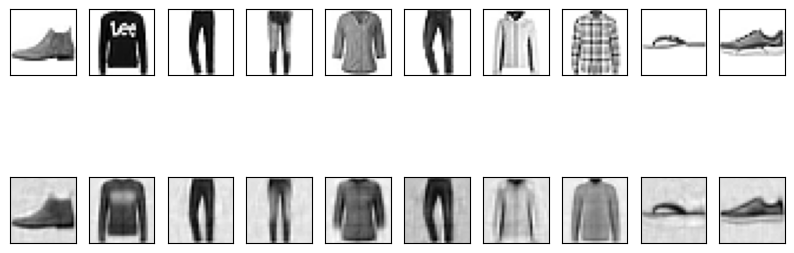

In [12]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval=200) # 모델 학습
    test_loss, real_image, gen_image = evaluate(model, test_loader) # 모델 평가
    print("\n-------------------------------------------------------------------------------------")
    print(f"Epoch {epoch}:      Test Loss: {test_loss:.4f}")
    print("-------------------------------------------------------------------------------------\n")

    f, a = plt.subplots(2, 10, figsize=(10, 4)) # 2행 10열의 서브플롯 생성

    for i in range(10):
        img = np.reshape(real_image[0][i], (28, 28)) # 실제 이미지 재구성
        a[0][i].imshow(img, cmap='gray_r') # 실제 이미지 출력
        a[0][i].set_xticks(()) # x축 눈금 제거
        a[0][i].set_yticks(()) # y축 눈금 제거

    for i in range(10):
        image = np.reshape(gen_image[0][i], (28, 28)) # 생성된 이미지 재구성
        a[1][i].imshow(image, cmap='gray_r') # 생성된 이미지
        a[1][i].set_xticks(()) # x축 눈금 제거
        a[1][i].set_yticks(()) # y축 눈금 제거

    plt.show() # 이미지 출력